# Collaborative Filtering Models

In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import os
from datetime import datetime
import surprise 
from sklearn.model_selection import train_test_split
from surprise.model_selection import GridSearchCV, KFold
from surprise import SVD
from IESEGRecSys import eval
from surprise import KNNBasic, SVD, CoClustering, Dataset, Reader

In [3]:
os.getcwd()

'c:\\Users\\warfaoui\\OneDrive - IESEG\\Desktop\\Recommendation Tools\\group_proj\\RecSys\\Recommendation-System'

## Data Loading

In [4]:
artist_df = pd.read_table('Data/Data Group Assignment/Artists.dat')

In [5]:
artist_df.head()

,id,name,url,pictureURL
0,1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,http://userserve-ak.last.fm/serve/252/10808.jpg
1,2,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,http://userserve-ak.last.fm/serve/252/3052066.jpg
2,3,Carpathian Forest,http://www.last.fm/music/Carpathian+Forest,http://userserve-ak.last.fm/serve/252/40222717...
3,4,Moi dix Mois,http://www.last.fm/music/Moi+dix+Mois,http://userserve-ak.last.fm/serve/252/54697835...
4,5,Bella Morte,http://www.last.fm/music/Bella+Morte,http://userserve-ak.last.fm/serve/252/14789013...


In [6]:
tags_df = pd.read_table('Data/Data Group Assignment/tags.dat',encoding='latin-1')

In [7]:
tags_df.head()

,tagID,tagValue
0,1,metal
1,2,alternative metal
2,3,goth rock
3,4,black metal
4,5,death metal


In [8]:
user_artists_df = pd.read_table('Data/Data Group Assignment/user_artists.dat')

In [9]:
user_artists_df.head()

,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983


In [10]:
user_taggedartists_df = pd.read_table('Data/Data Group Assignment/user_taggedartists.dat')

In [11]:
user_taggedartists_df.head()

,userID,artistID,tagID,day,month,year
0,2,52,13,1,4,2009
1,2,52,15,1,4,2009
2,2,52,18,1,4,2009
3,2,52,21,1,4,2009
4,2,52,41,1,4,2009


## EDA 

(0.0, 352698.0)

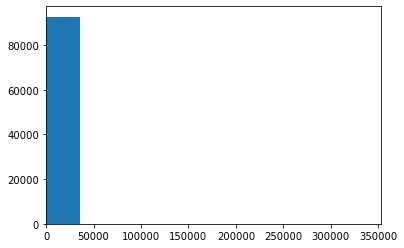

In [12]:
#entire range of weights
plt.hist(user_artists_df.weight)
plt.xlim(0,user_artists_df.weight.max())

(0.0, 50000.0)

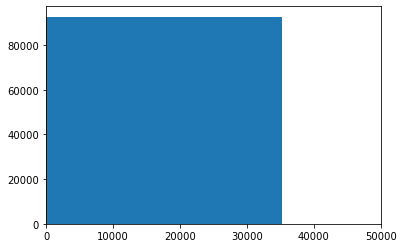

In [13]:
plt.hist(user_artists_df.weight)
plt.xlim(0,50000)

In [14]:
user_artists_df.iloc[user_artists_df['weight'].idxmax()]

userID        1642
artistID        72
weight      352698
Name: 72739, dtype: int64

In [15]:
user_artists_df.weight.value_counts()

1        636
2        419
4        345
3        338
5        318
        ... 
2087       1
12384      1
3722       1
2151       1
2049       1
Name: weight, Length: 5436, dtype: int64

{'whiskers': [<matplotlib.lines.Line2D at 0x1c84b0bf670>,
 'caps': [<matplotlib.lines.Line2D at 0x1c84b0bfcd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c84b0bf310>],
 'medians': [<matplotlib.lines.Line2D at 0x1c84b0ce3d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c84b0ce730>],
 'means': []}

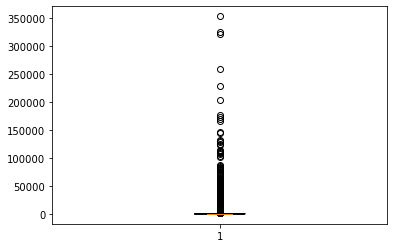

In [16]:
plt.boxplot(user_artists_df.weight, notch=True)

In [17]:
user_artists_df.weight.describe()

count     92834.00000
mean        745.24393
std        3751.32208
min           1.00000
25%         107.00000
50%         260.00000
75%         614.00000
max      352698.00000
Name: weight, dtype: float64

## Data Preprocessing

In [18]:
#discretize weights using qcuts 
user_artists_df['weight_quantiles'] = pd.qcut(user_artists_df['weight'],
                           q=[0,.2,.4,.6,.8,1],
                           labels=False,
                           precision=0)

In [19]:
user_artists_df.weight_quantiles.value_counts()

0    18770
3    18581
4    18548
2    18469
1    18466
Name: weight_quantiles, dtype: int64

In [20]:
#new df only replacing the countinous and skewed weights with the new discretized weight var
UA_df_cf = user_artists_df[['userID','artistID','weight_quantiles']]

## Train/Test Split

In [21]:
#create train and test sets 
UA_train, UA_test = train_test_split(UA_df_cf,test_size=0.3,random_state=123)

UA_train = UA_train.reset_index(drop=True)
UA_test = UA_test.reset_index(drop=True)

In [22]:
#create reader object 
reader = surprise.Reader(rating_scale=(1,5)) #1:5 scale 

#create surprise train and test set objects
data = surprise.Dataset.load_from_df(UA_df_cf[["userID","artistID","weight_quantiles"]], reader)
UA_train = surprise.Dataset.load_from_df(UA_train, reader).build_full_trainset()
UA_test = list(UA_test.itertuples(index=False, name=None))

## Baseline model predictions

### User-based KNNBasic

In [23]:
#get baseline KNN score 
from surprise import KNNBasic

# create options dict; use cosine similarity on user_based data
options = {'name':'cosine', 'user_based':True}

ubKNN = KNNBasic(k=20, min_k=2, sim_options=options, random_state=123)

#create cosine similarity matrix
ubKNN.fit(UA_train)\
.compute_similarities()


Computing the cosine similarity matrix...
Done computing similarity matrix.

C:\tools\Anaconda3\envs\py\lib\site-packages\surprise\prediction_algorithms\algo_base.py:249: RuntimeWarning: invalid value encountered in double_scalars
  sim = construction_func[name](*args)



Computing the cosine similarity matrix...
Done computing similarity matrix.


array([[1.        , 1.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       [1.        , 1.        , 0.96559438, ..., 0.        , 0.        ,
        1.        ],
       [1.        , 0.96559438, 1.        , ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 1.        , 1.        , ..., 0.        , 0.        ,
        1.        ]])

In [24]:
from surprise import accuracy

ubKNNpreds = ubKNN.test(UA_test)

ubKNNAccuracy = accuracy.rmse(ubKNNpreds)

# percentage impossible predictions
perc_impossible = np.sum([1 for i in ubKNNpreds if i.details["was_impossible"]]) / len(ubKNNpreds)
print(f"Impossible: {perc_impossible:.4f}")

RMSE: 1.4224
Impossible: 0.2671


* High RMSE and relatively high porportion of impossible predictions.

In [25]:
eval.evaluate(ubKNNpreds,topn=5,rating_cutoff=4)

,value
RMSE,1.422396
MAE,1.204500
Recall,0.002518
Precision,0.175000
F1,0.004965
NDCG@5,0.859066


### Item-based KNNBasic

In [26]:
#get baseline KNN score 
from surprise import KNNBasic

# create options dict; use cosine similarity on user_based data
options = {'name':'cosine', 'user_based':False}

ibKNN = KNNBasic(k=20, min_k=2, sim_options=options, random_state=123)

#create cosine similarity matrix
ibKNN.fit(UA_train)\
.compute_similarities()


Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


C:\tools\Anaconda3\envs\py\lib\site-packages\surprise\prediction_algorithms\algo_base.py:249: RuntimeWarning: invalid value encountered in double_scalars
  sim = construction_func[name](*args)


array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [27]:
from surprise import accuracy

ibKNNpreds = ibKNN.test(UA_test)

ibKNNAccuracy = accuracy.rmse(ibKNNpreds)

# percentage impossible predictions
perc_impossible = np.sum([1 for i in ibKNNpreds if i.details["was_impossible"]]) / len(ubKNNpreds)
print(f"Impossible: {perc_impossible:.4f}")

RMSE: 1.0805
Impossible: 0.2012


In [28]:
eval.evaluate(ibKNNpreds,topn=5,rating_cutoff=4)

,value
RMSE,1.080457
MAE,0.866984
Recall,0.156475
Precision,0.915789
F1,0.267281
NDCG@5,0.859624


### BaselineOnly

In [29]:
from surprise import BaselineOnly

#alternating least squares (ALS) with 30 iterations
options = {"method": "als", "n_epochs": 30}
als = BaselineOnly(bsl_options=options)

# fit on training set
als.fit(UA_train)

als_preds = als.test(UA_test)
als_accuracy = accuracy.rmse(als_preds)

# percentage impossible predictions
perc_impossible = np.sum([1 for i in als_preds if i.details["was_impossible"]]) / len(als_preds)
print(f"Impossible: {perc_impossible:.4f}")

Estimating biases using als...
RMSE: 0.9398
Impossible: 0.0000


In [30]:
eval.evaluate(als_preds,topn=5,rating_cutoff=4)

,value
RMSE,0.939793
MAE,0.786951
Recall,0.004856
Precision,0.870968
F1,0.009658
NDCG@5,0.864142


### SVD

In [31]:
from surprise import SVD

# 20 factors non-bias
svd = SVD(n_factors=20, biased=True, random_state=42)

# fit on training set
svd.fit(UA_train)

svd_preds = svd.test(UA_test)
svd_accuracy = accuracy.rmse(svd_preds)

# percentage impossible predictions
perc_impossible = np.sum([1 for i in svd_preds if i.details["was_impossible"]]) / len(svd_preds)
print(f"Impossible: {perc_impossible:.4f}")

RMSE: 0.9061
Impossible: 0.0000


In [32]:
eval.evaluate(svd_preds,topn=5,rating_cutoff=4)

,value
RMSE,0.906083
MAE,0.736482
Recall,0.063669
Precision,0.919481
F1,0.119092
NDCG@5,0.870266


### CoClustering 

In [33]:
from surprise import CoClustering

clust = CoClustering(n_cltr_u=10, n_cltr_i=10, n_epochs=50, random_state=42)

clust.fit(UA_train)

coclust_preds = clust.test(UA_test)
accuracy.rmse(coclust_preds)

# percentage impossible predictions
perc_impossible = np.sum([1 for i in coclust_preds if i.details["was_impossible"]]) / len(coclust_preds)
print(f"Impossible: {perc_impossible:.4f}")

<ipython-input-33-7fc309927928>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  clust.fit(UA_train)


RMSE: 1.0750
Impossible: 0.0000


In [34]:
eval.evaluate(coclust_preds,topn=5,rating_cutoff=4)

,value
RMSE,1.074960
MAE,0.864092
Recall,0.156115
Precision,0.745704
F1,0.258180
NDCG@5,0.860111


* The `SVD` algorithm showed the best results with respect to `RMSE`, `Precision` and `NDCG@5` with values of: 	0.906083, 0.919481, and 0.870266 respectively.

### CV Grid Search

We'll tune the hyperparameters of the `SVD` model as it gave us the best baseline results.

In [35]:
#grid search cross validation

#param_grid = {'n_factors':[20,50,150,200],
             #'n_epochs':[20,50],
             #'lr_all':[0.005, 0.001, 0.002],
             #'biased':[True],
             #'reg_all':[0.01,0.02]}

#3-fold grid searched cv 
#SVD_cv_grid = GridSearchCV(SVD,
                             #param_grid=param_grid,
                            #measures=['rmse','mae'],
                            #cv=3)
#SVD_cv_grid.fit(data)

In [36]:
#print(f"Best params with respect to RMSE: ",SVD_cv_grid.best_params['rmse'])
#print(f"Best params with respect to MAE: ",SVD_cv_grid.best_params['mae'])

In [37]:
#print(f"Best score with respect to RMSE: ",SVD_cv_grid.best_score['rmse'])
#print(f"Best score with respect to MAE: ",SVD_cv_grid.best_score['mae'])

### Final Predictions for Most Performant Algorithm: `SVD`

The cross-validated grid search in the above code cells provided us with the following optimal hyperparameters. 

* `n_factors` : 20
* `n_epochs`: 20
* `lr_all`: 0.005
* `biased`: True
* `reg_all`: 0.01

In [38]:
# with tuned hyperparameters
svd_best = SVD(n_factors=20, n_epochs=20,lr_all=0.005, biased=True, reg_all=0.01, random_state=42)

# fit on training set
svd_best.fit(UA_train)

#final predict
svd_best_preds = svd_best.test(UA_test)
svd_accuracy_best = accuracy.rmse(svd_best_preds)

RMSE: 0.9061


## Final Model Evaluation for `SVD` (Matrix Factorization)

In [39]:
eval.evaluate(prediction=svd_best_preds, topn=5, rating_cutoff=4, excl_impossible=True)

Excluded 0 (27851) samples. 27851 remaining ...
Excluded 0 (27851) samples. 27851 remaining ...


,value
RMSE,0.906055
MAE,0.735878
Recall,0.067806
Precision,0.915049
F1,0.126256
NDCG@5,0.870867


## Content Based Model

In [40]:
def two_dig(num):
    """
    This function takes a number as input and casts it to a string. 
    If the length of the str is equal to 1 it concatenates a 0 in front of it.
    This can be applyed to day and month columns that are recorded a single digit 
    in order to meet the two-digit format native to most datetime formats. 
    
    Params: num: A 
    """
    if len(str(num)) == 1:
        return((str(0) + str(num)))
    else:
        return(str(num))

## Loading Data

In [41]:
# creating day and month columns in order to create datetime release_date col
user_taggedartists_df['day'] = user_taggedartists_df['day'].map(lambda x: two_dig(x))
user_taggedartists_df['month'] = user_taggedartists_df['month'].map(lambda x: two_dig(x))
user_taggedartists_df['release_date'] = pd.to_datetime((user_taggedartists_df['year'].astype('str') + user_taggedartists_df['day'] + user_taggedartists_df['month']),format='%Y%d%m')

### Feature Engineering

(array([4.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 2.13500e+03, 1.84339e+05]),
 array([-4962. , -2955.5,  -949. ,  1057.5,  3064. ,  5070.5,  7077. ,
         9083.5, 11090. , 13096.5, 15103. ]),
 <BarContainer object of 10 artists>)

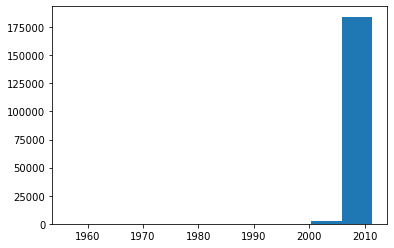

In [42]:
#visualize the skew of dates
plt.hist(user_taggedartists_df['release_date'])

In [43]:
thresholdMin = pd.to_datetime('1956-06-01')
thresholdVeryOld = pd.to_datetime('1970-01-01') # represents the range from 1956 - 1970 
thresholdOld = pd.to_datetime('1984-01-01')# represents the range from 1970 - 1984 
thresholdNew = pd.to_datetime('2010-01-01')# represents the range from 1984 - 2005 
thresholdVeryNew = pd.to_datetime('2012-01-01')# represents the range from 2005 - 2012

In [44]:
user_taggedartists_df[["very_old","old","new","very_new"]] = 0

user_taggedartists_df.loc[(user_taggedartists_df["release_date"] >= thresholdMin) & (user_taggedartists_df["release_date"] < thresholdVeryOld),"very_old"] = 1 
user_taggedartists_df.loc[(user_taggedartists_df["release_date"] >= thresholdVeryOld) & (user_taggedartists_df["release_date"] < thresholdOld),"old"] = 1
user_taggedartists_df.loc[(user_taggedartists_df["release_date"]>= thresholdOld) & (user_taggedartists_df["release_date"]  < thresholdNew),"new"] = 1
user_taggedartists_df.loc[(user_taggedartists_df["release_date"] >= thresholdNew) & (user_taggedartists_df["release_date"]< thresholdVeryNew),"very_new"] = 1

In [45]:
# merge together to get the full list of artist IDs
user_taggedartists_df=pd.merge(user_artists_df,user_taggedartists_df, on="artistID",how='left').fillna(0)

In [46]:
# drop uneeded columns
user_taggedartists_df = user_taggedartists_df[["userID_x","artistID","tagID","very_old","old","new","very_new"]]
user_taggedartists_df.columns =["userID","artistID","tagID","very_old","old","new","very_new"]

In [47]:
user_taggedartists_df["recency"]= user_taggedartists_df[["very_old","old","new","very_new"]].eq(1.0).idxmax(axis=1)

In [48]:
user_taggedartists_df =  user_taggedartists_df[["userID","artistID","tagID","recency"]]

In [49]:
#merging the dataset for content-based 
df_content_based = pd.merge(user_taggedartists_df,tags_df,on="tagID",how="left").fillna(0)

In [50]:
df_content_based.head()

,userID,artistID,tagID,recency,tagValue
0,2,51,16.0,new,new wave
1,2,51,25.0,new,80s
2,2,51,16.0,very_new,new wave
3,2,51,25.0,very_new,80s
4,2,51,16.0,new,new wave


In [51]:
#pivoting the table (creating a dummies table)
df_content_based_1 = df_content_based.pivot_table(index=["artistID"], columns ="tagValue", aggfunc={'tagValue':np.count_nonzero}).fillna(0)

In [52]:
#pivoting the table (creating a dummies table)
df_content_based_2 = df_content_based.pivot_table(index=["artistID"], columns ="recency", aggfunc={'recency':np.count_nonzero}).fillna(0)

In [53]:
df_content_based_1= pd.DataFrame(df_content_based_1)
df_content_based_2= pd.DataFrame(df_content_based_2)

In [54]:
df_content_based_2


recency                       
recency      new  old very_new very_old
artistID                               
1           42.0  0.0      3.0      0.0
2          240.0  0.0     84.0      0.0
3           24.0  0.0      3.0      0.0
4           36.0  0.0      8.0      0.0
5            8.0  0.0      6.0      0.0
...          ...  ...      ...      ...
18741        1.0  0.0      1.0      0.0
18742        0.0  0.0      0.0      1.0
18743        0.0  0.0      0.0      1.0
18744        4.0  0.0     10.0      0.0
18745        0.0  0.0      0.0      1.0

[17632 rows x 4 columns]

In [55]:
cb= pd.merge(df_content_based_1,df_content_based_2, how='left', left_index=True, right_index=True)

In [56]:
cb

tagValue                                                           \
tagValue        0 '80s -pearl fashion music 0 play yet   00 00's  007  00s   
artistID                                                                     
1             0.0  0.0                  0.0        0.0  0.0  0.0  0.0  0.0   
2             0.0  0.0                  0.0        0.0  0.0  0.0  0.0  0.0   
3             0.0  0.0                  0.0        0.0  0.0  0.0  0.0  0.0   
4             0.0  0.0                  0.0        0.0  0.0  0.0  0.0  0.0   
5             0.0  0.0                  0.0        0.0  0.0  0.0  0.0  0.0   
...           ...  ...                  ...        ...  ...  ...  ...  ...   
18741         0.0  0.0                  0.0        0.0  0.0  0.0  0.0  0.0   
18742         0.0  0.0                  0.0        0.0  0.0  0.0  0.0  0.0   
18743         0.0  0.0                  0.0        0.0  0.0  0.0  0.0  0.0   
18744         0.0  0.0                  1.0        0.0  0.0  0.0  0.0  0.0   
18745         0.0  0.0                  0.0        0.0  0.0  0.0  0.0  0.0   

                        ...                                                   \
tagValue 00s rock    1  ... zombie rave zombieland zoocore zornish  ztt   zu   
artistID                ...                                                    
1             0.0  0.0  ...         0.0        0.0     0.0     0.0  0.0  0.0   
2             0.0  0.0  ...         0.0        0.0     0.0     0.0  0.0  0.0   
3             0.0  0.0  ...         0.0        0.0     0.0     0.0  0.0  0.0   
4             0.0  0.0  ...         0.0        0.0     0.0     0.0  0.0  0.0   
5             0.0  0.0  ...         0.0        0.0     0.0     0.0  0.0  0.0   
...           ...  ...  ...         ...        ...     ...     ...  ...  ...   
18741         0.0  0.0  ...         0.0        0.0     0.0     0.0  0.0  0.0   
18742         0.0  0.0  ...         0.0        0.0     0.0     0.0  0.0  0.0   
18743         0.0  0.0  ...         0.0        0.0     0.0     0.0  0.0  0.0   
18744         0.0  0.0  ...         0.0        0.0     0.0     0.0  0.0  0.0   
18745         0.0  0.0  ...         0.0        0.0     0.0     0.0  0.0  0.0   

         recency                         
tagValue     new  old very_new very_old  
artistID                                 
1           42.0  0.0      3.0      0.0  
2          240.0  0.0     84.0      0.0  
3           24.0  0.0      3.0      0.0  
4           36.0  0.0      8.0      0.0  
5            8.0  0.0      6.0      0.0  
...          ...  ...      ...      ...  
18741        1.0  0.0      1.0      0.0  
18742        0.0  0.0      0.0      1.0  
18743        0.0  0.0      0.0      1.0  
18744        4.0  0.0     10.0      0.0  
18745        0.0  0.0      0.0      1.0  

[17632 rows x 9723 columns]

In [57]:
cb["new"] =0
cb["old"]=0
cb["very_new"]=0
cb["very_old"]=0

In [58]:
cb.loc[cb['recency',                  'new']>=1,'new']=1
cb.loc[cb['recency',                  'old']>=1,'old']=1
cb.loc[cb['recency',                  'very_new']>=1,'very_new']=1
cb.loc[cb['recency',                  'very_old']>=1,'very_old']=1

In [59]:
cb = cb.drop([( 'recency',                  'new'),
            ( 'recency',                  'old'),
            ( 'recency',             'very_new'),
            ( 'recency',             'very_old')], axis=1)

In [60]:
cb.head()

tagValue                                                           \
tagValue        0 '80s -pearl fashion music 0 play yet   00 00's  007  00s   
artistID                                                                     
1             0.0  0.0                  0.0        0.0  0.0  0.0  0.0  0.0   
2             0.0  0.0                  0.0        0.0  0.0  0.0  0.0  0.0   
3             0.0  0.0                  0.0        0.0  0.0  0.0  0.0  0.0   
4             0.0  0.0                  0.0        0.0  0.0  0.0  0.0  0.0   
5             0.0  0.0                  0.0        0.0  0.0  0.0  0.0  0.0   

                        ...                                                   \
tagValue 00s rock    1  ... zombie rave zombieland zoocore zornish  ztt   zu   
artistID                ...                                                    
1             0.0  0.0  ...         0.0        0.0     0.0     0.0  0.0  0.0   
2             0.0  0.0  ...         0.0        0.0     0.0     0.0  0.0  0.0   
3             0.0  0.0  ...         0.0        0.0     0.0     0.0  0.0  0.0   
4             0.0  0.0  ...         0.0        0.0     0.0     0.0  0.0  0.0   
5             0.0  0.0  ...         0.0        0.0     0.0     0.0  0.0  0.0   

         new old very_new very_old  
tagValue                            
artistID                            
1          1   0        1        0  
2          1   0        1        0  
3          1   0        1        0  
4          1   0        1        0  
5          1   0        1        0  

[5 rows x 9723 columns]

In [61]:
len(cb)

17632

## Applying content based rec sys

In [62]:
from sklearn.metrics.pairwise import cosine_similarity
import surprise

# Content Based as a Class
class ContentBased:

    def __init__(self, NN):
        self.NN = NN
        self.fitted = {"content":False, "ratings":False}
        
    def fit(self, content_data):

        self.items = content_data.index.values
        self.item_dim = len(self.items)
        # check for duplicate items
        assert (len(self.items) == len(set(self.items))), "Duplicate items in content data!"

        # compute similarity
        self.matrix = cosine_similarity(content_data.values)
        np.fill_diagonal(self.matrix, 0)
        
        self.matrixNN = self.matrix.copy()

        # filter similarity matrix for NN nearest neighbors (constraint: non-negative similarity)
        for i in range(self.item_dim):
            crit_val = max(-np.sort(-self.matrix[i])[self.NN-1], 0)
            self.matrixNN[i][self.matrixNN[i] < crit_val] = 0.0
        
        self.fitted["content"] = True

    # helper -> transform surprise.trainset.Trainset to pd.DataFrame
    def _trainset2list(self, trainset):
        return pd.DataFrame([(trainset.to_raw_uid(u), trainset.to_raw_iid(i), r) for (u, i, r) in trainset.all_ratings()], columns=["user", "item", "rating"])

    def fit_ratings(self, df):

        if not self.fitted["content"]:
            raise Exception("Fit model on content data!")

        if isinstance(df, surprise.trainset.Trainset):
            df = self._trainset2list(df)
        
        # fix unknown items
        unknown_items = list(set(df["item"]) - set(self.items))
        if len(unknown_items) > 0:
            print(f"Warning {len(unknown_items)} items are not included in content data: {unknown_items}")
        df = df[df["item"].isin(self.items)].reset_index(drop=True)

        # store user data
        self.users = np.unique(df["user"])
        self.user_dim = len(self.users)

        # fix missing items
        missing_items = list(set(self.items) - set(df["item"]))
        if len(missing_items) > 0: 
            fix_df = pd.DataFrame([{"user":np.nan, "item":i, "rating":np.nan} for i in missing_items])
            df = df.append(fix_df).reset_index(drop=True)

        # pivot 
        df_pivot = df.pivot_table(index='user', values='rating', columns='item', dropna=False).reindex(self.users)

        # row-wise (user) average
        self.user_avg = np.array(np.mean(df_pivot, axis=1))
        self.global_mean = np.mean(self.user_avg)

        # center ratings
        df_pivot = df_pivot.sub(self.user_avg, axis=0).fillna(0)

        # predict ratings for each item 
        denom = self.matrixNN.sum(axis=0) # column sums
        self.prediction = (np.matmul(df_pivot.values, self.matrixNN) / denom) + self.user_avg[:,np.newaxis]

        # replace NA values with mean
        # prediction[np.isnan(prediction)] = self.global_mean

        self.fitted["ratings"] = True
    
    # get predicted value for user-item combination
    def predict(self, user, item, r_ui=None):
        details = {"was_impossible":False}

        # check whether user and item are unknown -> default = global average rating
        if self.knows_user(user) & self.knows_item(item):

            # convert user & item in internal ids
            iid = np.where(self.items == item)[0].item()
            uid = np.where(self.users == user)[0].item()

            # inference prediction
            est = self.prediction[uid, iid]
            
            if np.isnan(est): 
                est = self.global_mean
                details["was_impossible"] = True
            return surprise.Prediction(user, item, r_ui, est, details)
        
        else:
            details["was_impossible"] = True
            details["reason"] = "User or item unknown"
            return surprise.Prediction(user, item, r_ui, self.global_mean, details)

    # predict entire testset
    def test(self, testset):
        if not self.fitted["ratings"]:
            raise Exception("Fit model on ratings data!")
        return [self.predict(user=u,item=i,r_ui=r) for (u,i,r) in testset]

    def knows_user(self, user):
        return user in self.users   

    def knows_item(self, item):
        return item in self.items        

    # get topn most similar items 
    def get_most_similar(self, item, topn=5):

        # get iid
        if self.knows_item(item):
            iid = np.where(self.items == item)[0].item()
        else:
            raise Exception(f"Item {item} unknown ...")
        
        list_iids = (-self.matrix[iid]).argsort()[:topn]
        return self.items[list_iids]

    def get_similarities(self):
        print('Cosine similarities shape: ({}, {}) items x items'.format(self.item_dim, self.item_dim))
        return self.matrix

In [63]:
# init content-based
cb_mod = ContentBased(NN=10)

# fit on content
cb_mod.fit(cb)

# fit on train_ratings
cb_mod.fit_ratings(UA_train)


<ipython-input-62-358ca43c89df>:71: RuntimeWarning: invalid value encountered in true_divide
  self.prediction = (np.matmul(df_pivot.values, self.matrixNN) / denom) + self.user_avg[:,np.newaxis]


In [64]:
cb_pred = cb_mod.test(UA_test)

In [65]:
# compute metrics for CB RS
cb_res = eval.evaluate(cb_pred, topn=5, rating_cutoff=3.5).rename(columns={'value':'Content_based_10'})
cb_res

,Content_based_10
RMSE,0.891378
MAE,0.669223
Recall,0.386871
Precision,0.760339
F1,0.512814
NDCG@5,0.872620


In [66]:
# bechnmark models
models = {"Content Based":cb_pred, "SVD":svd_preds}
overview = pd.concat([eval.evaluate(mod, topn=5, rating_cutoff=3) for mod in models.values()], axis=1)
overview.columns = list(models.keys())
overview

,Content Based,SVD
RMSE,0.891378,0.906083
MAE,0.669223,0.736482
Recall,0.505540,0.488965
Precision,0.917293,0.929770
F1,0.651838,0.640888
NDCG@5,0.872620,0.870266


## Applying Hybrid rec sys

In [67]:
# Combine predictions (weights)

# extract predictions content-based and item-based
df_pred_cb, df_pred_svd = pd.DataFrame(cb_pred), pd.DataFrame(svd_preds)

df_hybrid = df_pred_cb.copy()
df_hybrid['est'] = (np.array(df_pred_cb['est'])*0.6) + (np.array(df_pred_svd['est'])*0.4)

df_hybrid.head()

,uid,iid,r_ui,est,details
0,843,10570,0,0.479301,{'was_impossible': False}
1,189,492,3,2.886367,{'was_impossible': False}
2,227,543,1,2.543021,{'was_impossible': False}
3,1340,10662,3,2.316920,{'was_impossible': True}
4,517,703,2,1.378749,{'was_impossible': False}


In [68]:
eval.evaluate(df_hybrid,topn=5,rating_cutoff=3)

,value
RMSE,0.871708
MAE,0.690477
Recall,0.496712
Precision,0.930947
F1,0.647791
NDCG@5,0.861735


In [69]:
# Random Forest Hybrid 
df_cb_train, df_cb_test = df_pred_cb[:19500], df_pred_cb[19500:]
df_svd_train, df_svd_test = df_pred_svd[:19500], df_pred_svd[19500:]

In [96]:
rf_data = df_cb_train[['uid','iid','r_ui','est']].rename(columns={'uid':'user','iid':'artist','r_ui':'ratings','est':'cb_pred'})
rf_data['svd_pred'] = df_svd_train['est']
rf_data.head()

,user,artist,ratings,cb_pred,svd_pred
0,843,10570,0,0.132169,1.000000
1,189,492,3,2.974464,2.754220
2,227,543,1,2.699498,2.308306
3,1340,10662,3,1.974467,2.830599
4,517,703,2,1.405405,1.338765


In [71]:
rf_test = df_cb_test[['r_ui', 'est']].rename(columns={'r_ui':'target', 'est':'cb_pred'})
rf_test['svd_pred'] = df_svd_test['est']
rf_test.head()

,target,cb_pred,svd_pred
19500,4,2.369420,2.828775
19501,1,0.645668,1.000000
19502,3,1.974467,2.504190
19503,4,3.944921,4.029542
19504,2,1.114286,1.190672


In [100]:
from sklearn.ensemble import RandomForestRegressor

X, y = rf_data.loc[:,['cb_pred','svd_pred']], np.array(rf_data['ratings'])
X_test = rf_test.loc[:,rf_test.columns != 'ratings']
# fit random forest model
rf_model = RandomForestRegressor(max_depth=4, n_estimators=100).fit(X,y)

In [73]:
# predict
rf_pred = rf_model.predict(X_test)

In [74]:
# transform in surprise format
df_rf = df_cb_test.copy()
df_rf['est'] = rf_pred

In [75]:
eval.prediction_metrics(df_rf).rename(columns={'value':'Hybrid_RF'})

,Hybrid_RF
RMSE,0.847461
MAE,0.642739


## Top N artist for specific user

In [133]:
def predict_user_topn(model, train, user, topk=15, item_col='artist'):

    # iter through all items contained in train set
    for item in set(train[item_col]) :
        
        X = train.loc[train['user']==user,['cb_pred','svd_pred']]
        pred = model.predict(X)
        # save to result dict
        res = train.loc[train['user']==user,['user','artist','ratings']].copy()
        res['est'] = pred
        art_id = list(pd.DataFrame(res).sort_values('est', ascending=False)[:topk][item_col])
    return artist_df.loc[artist_df['id'].isin(art_id),"name"]

In [134]:
predict_user_topn(rf_model,rf_data,189,topk=15,item_col='artist')

167                   Placebo
184                      Muse
227           Nine Inch Nails
430     The Smashing Pumpkins
486      Funeral for a Friend
973              Foo Fighters
3868          Hundred Reasons
3869                   Feeder
Name: name, dtype: object